In [1]:
from transformers import PreTrainedModel, AutoModelForQuestionAnswering, AutoTokenizer, AutoFeatureExtractor, LayoutLMv3Model, LayoutLMv3Config, BartModel
import os
from PIL import Image, ImageOps
import numpy as np
import random
import collections
from datasets import load_from_disk

import seaborn as sns

from matplotlib import pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from timm.models.layers import to_2tuple

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

    
from modelling.tokenization import tokenize_dataset
from modelling.data_collator import DocVQACollator

/home/jmorales/anaconda3/envs/tfg/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class PatchEmbed(nn.Module):
    """LayoutLMv3 image (patch) embeddings. This class also automatically interpolates the position embeddings for varying
    image sizes."""

    def __init__(self, config):
        super().__init__()

        image_size = (
            config.input_size
            if isinstance(config.input_size, collections.abc.Iterable)
            else (config.input_size, config.input_size)
        )
        patch_size = (
            config.patch_size
            if isinstance(config.patch_size, collections.abc.Iterable)
            else (config.patch_size, config.patch_size)
        )
        self.patch_shape = (image_size[0] // patch_size[0], image_size[1] // patch_size[1])
        self.proj = nn.Conv2d(config.num_channels, config.hidden_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, pixel_values, position_embedding=None):
        embeddings = self.proj(pixel_values)

        #embeddings = embeddings.flatten(2).transpose(1, 2)
        return embeddings

# Change pos_embed  
# cls_token = nn.Parameter(torch.zeros(1, 1, config.hidden_size))
# pos_embed = nn.Parameter(torch.zeros(1, size * size + 1, config.hidden_size))
def forward_image(pixel_values):
        embedder = PatchEmbed(model.layoutlmv3.config)
        embeddings = embedder(pixel_values)
        return embeddings

In [7]:
dataset_info = load_from_disk(
    "../cached_datasets/infographicvqa_all_lowercase_True_msr_ocr_True_extraction_v1_enumeration")
dataset_doc = load_from_disk(
    "../cached_datasets/docvqa_cached_extractive_all_lowercase_True_msr_ocr_True_extraction_v1_enumeration")

def get_image_dir(dataset_name):
    return {
        "train": f"../data/{dataset_name}/train", 
        "val": f"../data/{dataset_name}/val", 
        "test": f"../data/{dataset_name}/test"}

pretrained_model_name = "microsoft/layoutlmv3-base"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name, use_fast=True)
tokenized_doc = dataset_doc.map(tokenize_dataset,
                        fn_kwargs={"tokenizer": tokenizer("docvqa"),
                                   "img_dir": get_image_dir,
                                   "use_msr_ocr": True, # Maybe pass as parameter in the future
                                   "doc_stride": 0,
                                   "dataset": "docvqa", 
                                   "use_generation": False,
                                   "ignore_unmatched_answer_span_during_train": True},
                        batched=True, num_proc=1,
                        load_from_cache_file=False,
                        remove_columns=dataset["val"].column_names
                        )
tokenized_info = dataset_info.map(tokenize_dataset,
                        fn_kwargs={"tokenizer": tokenizer("infographicvqa"),
                                   "img_dir": image_dir,
                                   "use_msr_ocr": True, # Maybe pass as parameter in the future
                                   "doc_stride": 0,
                                   "dataset": "infographicvqa", 
                                   "use_generation": False,
                                   "ignore_unmatched_answer_span_during_train": True},
                        batched=True, num_proc=1,
                        load_from_cache_file=False,
                        remove_columns=dataset["val"].column_names
                        )

ValueError: Words must be of type `List[str]` (single pretokenized example), or `List[List[str]]` (batch of pretokenized examples).

In [12]:
x = torch.tensor([[[2, 2], [4, 3]]])
x.size()

torch.Size([1, 2, 2])

In [87]:
torch.randint(0,0, [1])

RuntimeError: random_ expects 'from' to be less than 'to', but got from=0 >= to=0

In [81]:
max_v = 40
max_h = 160
if torch.bernoulli(torch.tensor([max_v/max_h])) == 1:
    im_v = 23
    c =  int(torch.randint(0, max_v - im_v, [1]))
    print(c)
else:
    print(0)

0


In [4]:
feature_extractor = AutoFeatureExtractor.from_pretrained(pretrained_model_name, apply_ocr=False, do_resize=False)

In [2]:
pretrained_model_name = "microsoft/layoutlmv3-base"
model = AutoModelForQuestionAnswering.from_pretrained(pretrained_model_name)

Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.bias', 'qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [143]:
model.qa_outputs

LayoutLMv3ClassificationHead(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Linear(in_features=768, out_features=2, bias=True)
)

In [62]:
resize = False
model = AutoModelForQuestionAnswering.from_pretrained(pretrained_model_name)
collator = DocVQACollator1(
        tokenizer,
        feature_extractor,
        pretrained_model_name=pretrained_model_name,
        model=model,
        resize=resize,
        multiple_embeddings=False
        )
valid_dataloader = DataLoader(tokenized["val"].remove_columns("metadata"), batch_size=1,
                                                    collate_fn=collator, num_workers=1, shuffle=False)

Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.out_proj.bias', 'qa_outputs.dense.weight', 'qa_outputs.dense.bias', 'qa_outputs.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
count_matrix = np.zeros((200, 50), int)
fmap_list = []
for iter, batch in tqdm(enumerate(valid_dataloader, 1), desc="--training batch", total=len(valid_dataloader)):
    pixel_values = batch["pixel_values"]
    image_shape = pixel_values.shape[2:]
    #print("BATCH SHAPE", pixel_values.shape)
    #print("IMAGE SHAPE:", image_shape)
    
    embeddings = forward_image(pixel_values)
    patch_shape = embeddings.shape[2:]
    #print("FEATURE MAP", embeddings.shape[1:])
    #print(patch_shape[0]*patch_shape[1])
    count_matrix[:patch_shape[0], :patch_shape[1]] += 1
    fmap_list.append(list(patch_shape))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible


--training batch:   0%|                        | 1/5349 [00:00<14:15,  6.25it/s]

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--training batch: 100%|█████████████████████| 5349/5349 [06:20<00:00, 14.04it/s]


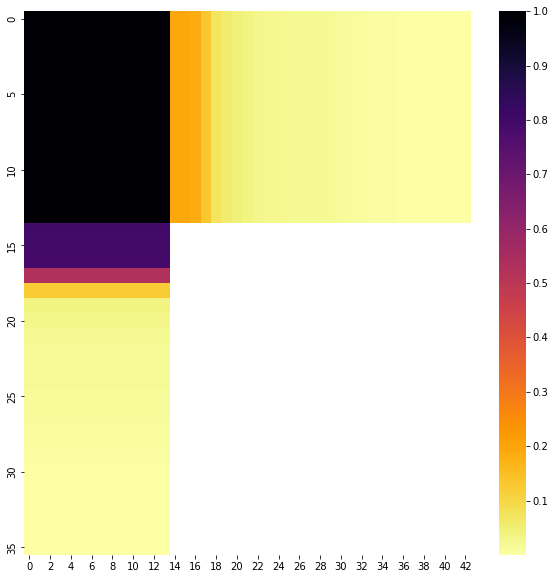

In [8]:
lims = np.max(np.array(fmap_list), axis=0)

plt.figure(figsize=(10, 10))
sns.heatmap(
    count_matrix[:lims[0],:lims[1]]/np.max(count_matrix), 
    cmap="inferno_r",
    xticklabels=2,
    yticklabels=5,
    cbar_kws=dict(ticks=np.arange(0.0, 1.01, 0.1)),
    mask=np.where(
        count_matrix[:lims[0],:lims[1]] == 0, 1, 0));

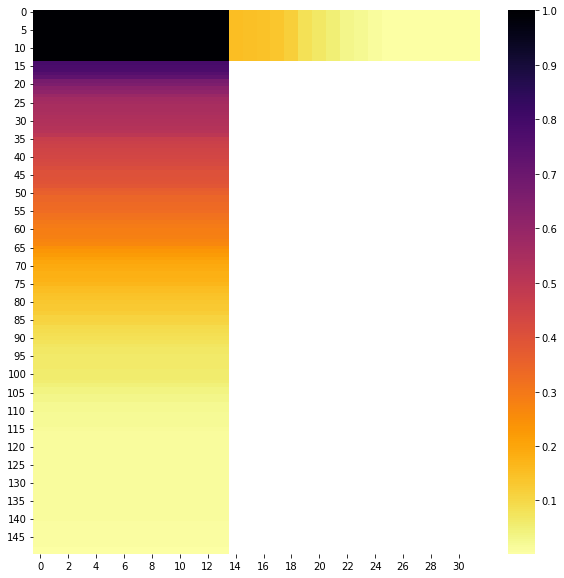

In [147]:
lims = np.max(np.array(fmap_list), axis=0)

plt.figure(figsize=(10, 10))
sns.heatmap(
    count_matrix[:lims[0],:lims[1]]/np.max(count_matrix), 
    cmap="inferno_r",
    xticklabels=2,
    yticklabels=5,
    cbar_kws=dict(ticks=np.arange(0.0, 1.01, 0.1)),
    mask=np.where(
        count_matrix[:lims[0],:lims[1]] == 0, 1, 0));

Vertical range: 150
Horizontal range: 32


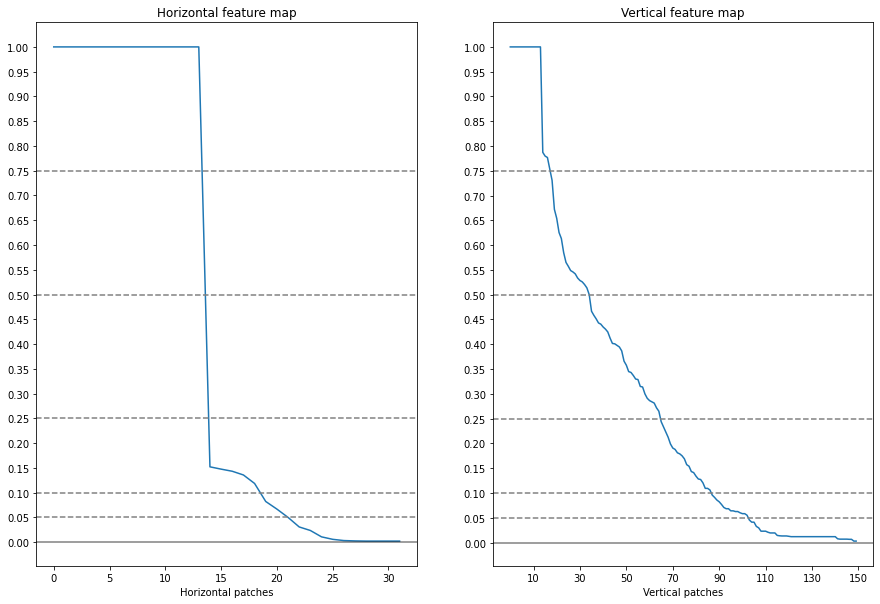

In [151]:
print("Vertical range:", lims[0])
print("Horizontal range:", lims[1])

maximum = np.max(count_matrix)
horizontal = count_matrix[0, :lims[1]] / maximum
vertical = count_matrix[:lims[0], 0] / maximum
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

ax[0].plot(horizontal);
ax[0].set_title("Horizontal feature map")
ax[0].axhline(0.75, color='gray',ls='--')
ax[0].axhline(0.5, color='gray',ls='--')
ax[0].axhline(0.25, color='gray',ls='--')
ax[0].axhline(0.1, color='gray',ls='--')
ax[0].axhline(0.05, color='gray',ls='--')
ax[0].axhline(0, color='black',ls='-', alpha=0.5)
ax[0].set_yticks(np.arange(0.0, 1.01, 0.05))
ax[0].set_xticks(np.arange(0.0, lims[1]+1, 5))
ax[0].set_xlabel("Horizontal patches")

ax[1].plot(vertical);
ax[1].set_title("Vertical feature map")
ax[1].axhline(0.75, color='gray',ls='--')
ax[1].axhline(0.5, color='gray',ls='--')
ax[1].axhline(0.25, color='gray',ls='--')
ax[1].axhline(0.1, color='gray',ls='--')
ax[1].axhline(0.05, color='gray',ls='--')
ax[1].axhline(0, color='black',ls='-', alpha=0.5)
ax[1].set_yticks(np.arange(0.0, 1.01, 0.05))
ax[1].set_xticks(np.arange(10.0, lims[0]+1, 20))
ax[1].set_xlabel("Vertical patches");

#### Preprocess
- Resize each image so that the shortest side has a length of 224, which can be covered by 14 16x16 patches.
- Each image has atleast a 14x14 patch area, plus more patches depending if the document is vertical or horizontal
- Other patch and image dimensions could be tried
- Instead of 224, we could use 320 (seems to work for all infographics), or an even bigger size, but we would have to discard those images that wouldn't fit in memory.

#### Main problems with the model
- By default, it resized each image to a 224x224 image -> 14x14 patch grid, it only used a 1D learnable positional embedding.
- We probably need to implement a 2D positional embedding.
    - X and Y learnable parameters that would be concatenated for the 2D embedding
- The 1D embedding could be removed or kept.

#### Doubts
- For data augmentation: When we create new documents with padding, should also modify the bounding boxes of the ocr?

- Train with docvqa or infographicsvqa?

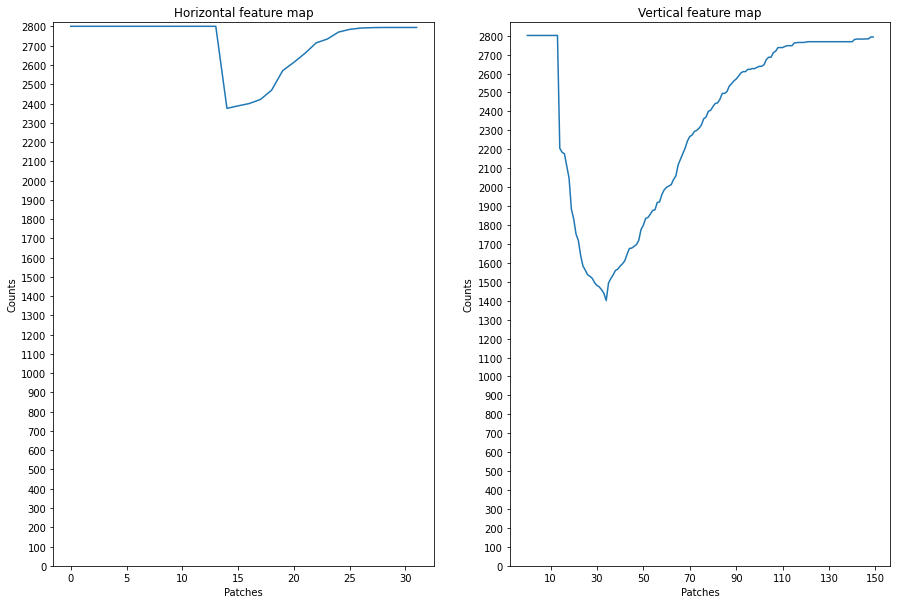

In [115]:
horizontal = count_matrix[0, :lims[1]]
vertical = count_matrix[:lims[0], 0]

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

ax[0].plot(np.maximum(horizontal, (np.max(horizontal) - horizontal)));
ax[0].set_title("Horizontal feature map")
ax[0].set_yticks(np.arange(0.0, max(vertical)+1, 100))
ax[1].set_xticks(np.arange(0.0, lims[1]+1, 5))
ax[0].set_xlabel("Patches")
ax[0].set_ylabel("Counts");

ax[1].plot(np.maximum(vertical, (np.max(vertical) - vertical)));
ax[1].set_title("Vertical feature map")
ax[1].set_yticks(np.arange(0.0, max(vertical)+1, 100))
ax[1].set_xticks(np.arange(10.0, lims[0]+1, 20))
ax[1].set_xlabel("Patches")
ax[1].set_ylabel("Counts");

In [3]:
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

graph = draw_graph(model.qa_outputs, input_size=(1, 768), device='meta')
graph.visual_graph

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

#### Feature extractor

In [131]:
feature_extractor = AutoFeatureExtractor.from_pretrained(pretrained_model_name, apply_ocr=False, size=224)

In [26]:
feature_extractor

LayoutLMv3FeatureExtractor {
  "apply_ocr": false,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "LayoutLMv3FeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "ocr_lang": null,
  "resample": 2,
  "size": 400,
  "tesseract_config": ""
}

In [32]:
def process_image(image):
    image_post = feature_extractor(image.convert("RGB"), return_tensors="np")["pixel_values"][0]
    img = Image.new("RGB", (224, 224))
    values = (((image_post*0.5) + 0.5)*255).astype(np.uint32)
    r = values[0].flatten().tolist()
    g = values[1].flatten().tolist()
    b = values[2].flatten().tolist()
    img.putdata(list(zip(r, g, b)))
    
    return img

In [92]:
# InfographicVQA
split = "train"
folder = os.listdir(f"../data/infographicvqa/{split}/infographicVQA_{split}_v1.0_images")
image = Image.open(f"../data/infographicvqa/{split}/infographicVQA_{split}_v1.0_images/{random.sample(folder, 1)[0]}")

In [118]:
# DocVQA
folder = os.listdir(f"../data/docvqa/{'train'}/documents")
image = Image.open(f"../data/docvqa/{'train'}/documents/{random.sample(folder, 1)[0]}")

(4880, 4881)


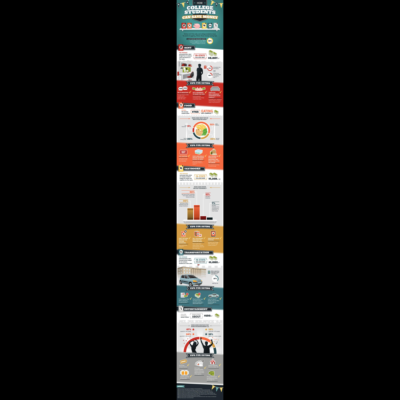

In [94]:
#TODO: add black stripes to create a squared image


size = image.size

a = int(np.floor((max(size) - min(size))/2))

# border = (left, top, right, bottom) 
border = (0, a, 0, a) if size[0] > size[1] else (a, 0, a, 0)    

color = "black"

new_image = ImageOps.expand(image, border=border, fill=color)
print(new_image.size)
process_image(new_image)

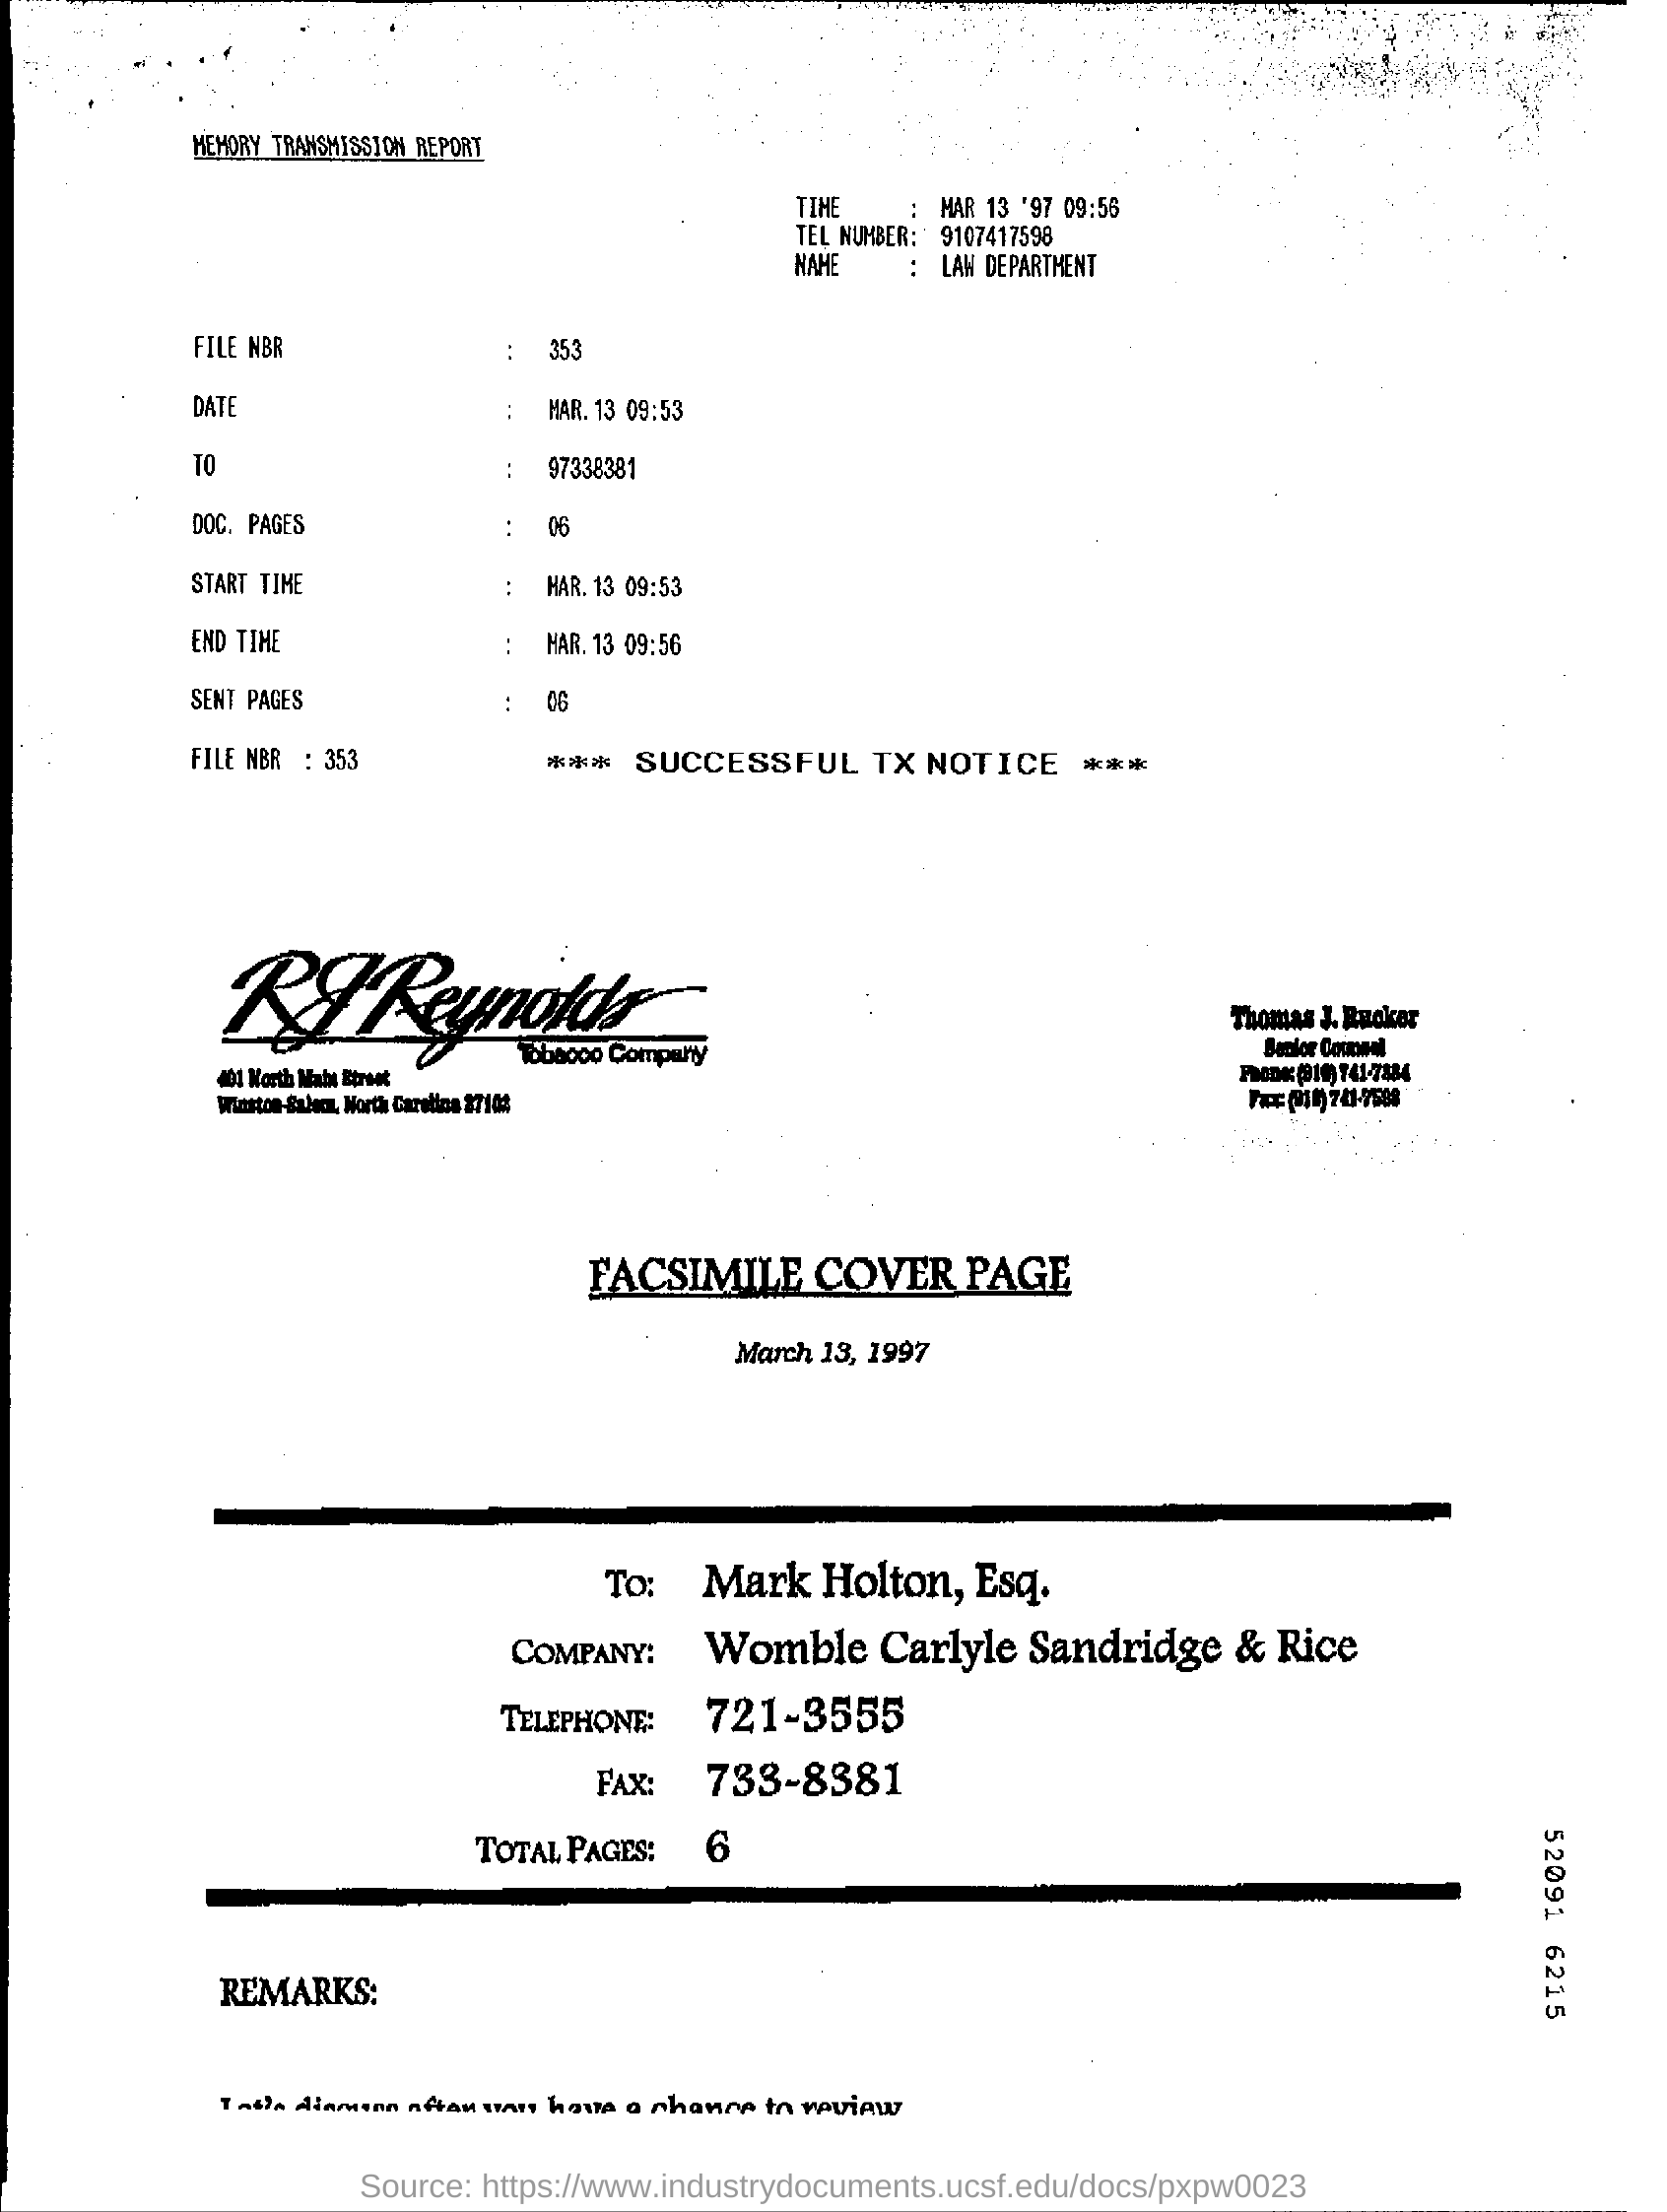

In [147]:
image.resize((200,20))
image.

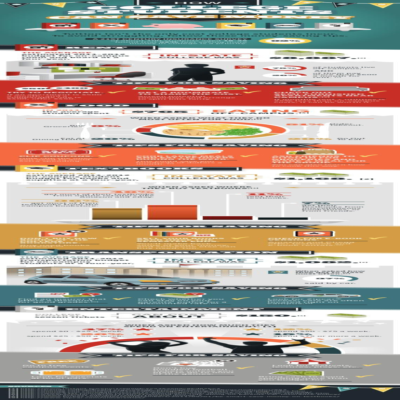

In [95]:
process_image(image)

In [151]:
checkpoint = torch.load(f"../model_files/docvqa_msr_ocr_finetune_base_50epoch_smaller_lr/state_dict.pth", map_location="cpu")

In [152]:
checkpoint.keys()

odict_keys(['layoutlmv3.cls_token', 'layoutlmv3.pos_embed', 'layoutlmv3.embeddings.position_ids', 'layoutlmv3.embeddings.word_embeddings.weight', 'layoutlmv3.embeddings.token_type_embeddings.weight', 'layoutlmv3.embeddings.LayerNorm.weight', 'layoutlmv3.embeddings.LayerNorm.bias', 'layoutlmv3.embeddings.position_embeddings.weight', 'layoutlmv3.embeddings.x_position_embeddings.weight', 'layoutlmv3.embeddings.y_position_embeddings.weight', 'layoutlmv3.embeddings.h_position_embeddings.weight', 'layoutlmv3.embeddings.w_position_embeddings.weight', 'layoutlmv3.patch_embed.proj.weight', 'layoutlmv3.patch_embed.proj.bias', 'layoutlmv3.LayerNorm.weight', 'layoutlmv3.LayerNorm.bias', 'layoutlmv3.norm.weight', 'layoutlmv3.norm.bias', 'layoutlmv3.encoder.layer.0.attention.self.query.weight', 'layoutlmv3.encoder.layer.0.attention.self.query.bias', 'layoutlmv3.encoder.layer.0.attention.self.key.weight', 'layoutlmv3.encoder.layer.0.attention.self.key.bias', 'layoutlmv3.encoder.layer.0.attention.self

In [6]:
model.config

LayoutLMv3Config {
  "_name_or_path": "microsoft/layoutlmv3-base",
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "input_size": 224,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_2d_position_embeddings": 1024,
  "max_position_embeddings": 514,
  "max_rel_2d_pos": 256,
  "max_rel_pos": 128,
  "model_type": "layoutlmv3",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "patch_size": 16,
  "rel_2d_pos_bins": 64,
  "rel_pos_bins": 32,
  "second_input_size": 112,
  "shape_size": 128,
  "text_embed": true,
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "visual_embed": true,
  "vocab_size": 50265
}

In [4]:
model.layoutlmv3.embeddings

LayoutLMv3TextEmbeddings(
  (word_embeddings): Embedding(50265, 768, padding_idx=1)
  (token_type_embeddings): Embedding(1, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (position_embeddings): Embedding(514, 768, padding_idx=1)
  (x_position_embeddings): Embedding(1024, 128)
  (y_position_embeddings): Embedding(1024, 128)
  (h_position_embeddings): Embedding(1024, 128)
  (w_position_embeddings): Embedding(1024, 128)
)